In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

## Credit risk scoring project

In [2]:
df = pd.read_csv('CreditScoring.csv')

In [3]:
df

,Status,Seniority,Home,Time,Age,Marital,Records,Job,Expenses,Income,Assets,Debt,Amount,Price
0,1,9,1,60,30,2,1,3,73,129,0,0,800,846
1,1,17,1,60,58,3,1,1,48,131,0,0,1000,1658
2,2,10,2,36,46,2,2,3,90,200,3000,0,2000,2985
3,1,0,1,60,24,1,1,1,63,182,2500,0,900,1325
4,1,0,1,36,26,1,1,1,46,107,0,0,310,910
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4450,2,1,1,60,39,2,1,1,69,92,0,0,900,1020
4451,1,22,2,60,46,2,1,1,60,75,3000,600,950,1263
4452,2,0,2,24,37,2,1,2,60,90,3500,0,500,963
4453,1,0,1,48,23,1,1,3,49,140,0,0,550,550


## Data preparation

- Lower case the column names

In [4]:
df.columns = df.columns.str.lower()

In [5]:
df.head(2)

,status,seniority,home,time,age,marital,records,job,expenses,income,assets,debt,amount,price
0,1,9,1,60,30,2,1,3,73,129,0,0,800,846
1,1,17,1,60,58,3,1,1,48,131,0,0,1000,1658


- Some of the categorical variables are encoded as numbers

See the documentation to check the meaning for each of the numbers in the columns https://github.com/gastonstat/CreditScoring

- Use the map method making use of dictionaries

In [6]:
df.status.unique()

array([1, 2, 0], dtype=int64)

In [7]:
status_values = {
    0: 'unk', 
    1: 'ok', 
    2: 'default'
}

df.status = df.status.map(status_values)

- Reuse this method to encode the other variables

In [8]:
home_values = {
    1: 'rent',
    2: 'owner',
    3: 'private',
    4: 'ignore',
    5: 'parents',
    6: 'other',
    0: 'unk'
}

marital_values = {
    1: 'single',
    2: 'married',
    3: 'widow',
    4: 'separated',
    5: 'divorced',
    0: 'unk'
}

records_values = {
    1: 'no',
    2: 'yes',
    0: 'unk'
}

job_values = {
    1: 'fixed',
    2: 'partime',
    3: 'freelance',
    4: 'others',
    0: 'unk'
}


df.home = df.home.map(home_values)
df.marital = df.marital.map(marital_values)
df.records = df.records.map(records_values)
df.job = df.job.map(job_values)

In [9]:
df.head()

,status,seniority,home,time,age,marital,records,job,expenses,income,assets,debt,amount,price
0,ok,9,rent,60,30,married,no,freelance,73,129,0,0,800,846
1,ok,17,rent,60,58,widow,no,fixed,48,131,0,0,1000,1658
2,default,10,owner,36,46,married,yes,freelance,90,200,3000,0,2000,2985
3,ok,0,rent,60,24,single,no,fixed,63,182,2500,0,900,1325
4,ok,0,rent,36,26,single,no,fixed,46,107,0,0,310,910


- Take a look at missing values

In [10]:
df.describe().round()

,seniority,time,age,expenses,income,assets,debt,amount,price
count,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0
mean,8.0,46.0,37.0,56.0,763317.0,1060341.0,404382.0,1039.0,1463.0
std,8.0,15.0,11.0,20.0,8703625.0,10217569.0,6344253.0,475.0,628.0
min,0.0,6.0,18.0,35.0,0.0,0.0,0.0,100.0,105.0
25%,2.0,36.0,28.0,35.0,80.0,0.0,0.0,700.0,1118.0
50%,5.0,48.0,36.0,51.0,120.0,3500.0,0.0,1000.0,1400.0
75%,12.0,60.0,45.0,72.0,166.0,6000.0,0.0,1300.0,1692.0
max,48.0,72.0,68.0,180.0,99999999.0,99999999.0,99999999.0,5000.0,11140.0


- income, assets and debt have a large max value. This is documented as being a missing value 

In [11]:
df.income.replace(to_replace = 99999999, value = np.nan)

0       129.0
1       131.0
2       200.0
3       182.0
4       107.0
        ...  
4450     92.0
4451     75.0
4452     90.0
4453    140.0
4454    140.0
Name: income, Length: 4455, dtype: float64

In [12]:
for c in ['income', 'assets', 'debt']:
    df[c] = df[c].replace(to_replace = 99999999, value = np.nan)

- Looking at the status column, there is one unk value, which is not usefull

In [13]:
df.status.value_counts()

ok         3200
default    1254
unk           1
Name: status, dtype: int64

Remove it and reset the index to keep them sequential

In [14]:
df = df[df.status != "unk"].reset_index(drop = True)

- Split the data

In [15]:
from sklearn.model_selection import train_test_split

df_full_train, df_test = train_test_split(df, test_size = 0.2, random_state = 11)
df_train, df_val = train_test_split(df_full_train, test_size = 0.25, random_state = 11)

In [16]:
df_train = df_train.reset_index(drop = True)
df_val = df_val.reset_index(drop = True)
df_test = df_test.reset_index(drop = True)

- Encode the status variable as 0 and 1

In [17]:
y_train = (df_train.status == 'default').astype('int').values

y_val = (df_val.status == 'default').astype('int').values

y_test = (df_test.status == 'default').astype('int').values

- remove the status variable from the data sets

In [18]:
del df_train['status']
del df_val['status']
del df_test['status']

## Decision trees

In [19]:
def assess_risk(client):
    if client['records'] == 'yes':
        if client['job'] == 'parttime':
            return 'default'
        else:
            return 'ok'
    else:
        if client['assets'] > 6000:
            return 'ok'
        else:
            return 'default'       

**Represent the Decision Tree from above in python code**

- Use an observation as an example

In [20]:
df_train.iloc[0].to_dict()

{'seniority': 10,
 'home': 'owner',
 'time': 36,
 'age': 36,
 'marital': 'married',
 'records': 'no',
 'job': 'freelance',
 'expenses': 75,
 'income': 0.0,
 'assets': 10000.0,
 'debt': 0.0,
 'amount': 1000,
 'price': 1400}

In [21]:
xi = df_train.iloc[0].to_dict()

In [22]:
assess_risk(xi)

'ok'

- The rules were hardcoded for this example, but our model can learn from the data what are the best rules to use

In [23]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import roc_auc_score

- Additionally, fillna with 0

In [24]:
train_dicts = df_train.fillna(0).to_dict(orient = 'records')

- first 5 observations

In [25]:
train_dicts[:5]

[{'seniority': 10,
  'home': 'owner',
  'time': 36,
  'age': 36,
  'marital': 'married',
  'records': 'no',
  'job': 'freelance',
  'expenses': 75,
  'income': 0.0,
  'assets': 10000.0,
  'debt': 0.0,
  'amount': 1000,
  'price': 1400},
 {'seniority': 6,
  'home': 'parents',
  'time': 48,
  'age': 32,
  'marital': 'single',
  'records': 'yes',
  'job': 'fixed',
  'expenses': 35,
  'income': 85.0,
  'assets': 0.0,
  'debt': 0.0,
  'amount': 1100,
  'price': 1330},
 {'seniority': 1,
  'home': 'parents',
  'time': 48,
  'age': 40,
  'marital': 'married',
  'records': 'no',
  'job': 'fixed',
  'expenses': 75,
  'income': 121.0,
  'assets': 0.0,
  'debt': 0.0,
  'amount': 1320,
  'price': 1600},
 {'seniority': 1,
  'home': 'parents',
  'time': 48,
  'age': 23,
  'marital': 'single',
  'records': 'no',
  'job': 'partime',
  'expenses': 35,
  'income': 72.0,
  'assets': 0.0,
  'debt': 0.0,
  'amount': 1078,
  'price': 1079},
 {'seniority': 5,
  'home': 'owner',
  'time': 36,
  'age': 46,
  'm

In [26]:
dv = DictVectorizer(sparse = False)
X_train = dv.fit_transform(train_dicts)

In [27]:
X_train

array([[3.60e+01, 1.00e+03, 1.00e+04, ..., 0.00e+00, 1.00e+01, 3.60e+01],
       [3.20e+01, 1.10e+03, 0.00e+00, ..., 1.00e+00, 6.00e+00, 4.80e+01],
       [4.00e+01, 1.32e+03, 0.00e+00, ..., 0.00e+00, 1.00e+00, 4.80e+01],
       ...,
       [1.90e+01, 4.00e+02, 0.00e+00, ..., 0.00e+00, 1.00e+00, 2.40e+01],
       [4.30e+01, 2.50e+03, 1.80e+04, ..., 0.00e+00, 1.50e+01, 4.80e+01],
       [2.70e+01, 4.50e+02, 5.00e+03, ..., 1.00e+00, 1.20e+01, 4.80e+01]])

In [28]:
dv.get_feature_names()

['age',
 'amount',
 'assets',
 'debt',
 'expenses',
 'home=ignore',
 'home=other',
 'home=owner',
 'home=parents',
 'home=private',
 'home=rent',
 'home=unk',
 'income',
 'job=fixed',
 'job=freelance',
 'job=others',
 'job=partime',
 'job=unk',
 'marital=divorced',
 'marital=married',
 'marital=separated',
 'marital=single',
 'marital=unk',
 'marital=widow',
 'price',
 'records=no',
 'records=yes',
 'seniority',
 'time']

- Train the Decision Tree

In [29]:
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)

DecisionTreeClassifier()

- Test the model

In [30]:
val_dicts = df_val.fillna(0).to_dict(orient = 'records')
X_val = dv.transform(val_dicts)

Select the second column: probability of the customer belonging to the positive class

In [31]:
y_pred = dt.predict_proba(X_val)[:, 1]

- Compute the AUC

In [32]:
roc_auc_score(y_val, y_pred)

0.6521427187522705

- Lets compare the auc score for the train data set

In [33]:
y_pred = dt.predict_proba(X_train)[:, 1]
roc_auc_score(y_train, y_pred)

1.0

On the train data set the auc score was 1 and then it decrease on the validation data set to 0.65

This is called **overfitting:** the model memorizes the training data, but does not generalize well when it sees new observations because they don't look like any of the training data points.

- We want to retrain the tree but control it's **depth**. This avoids the model to learn rules that are to specific

In [34]:
dt = DecisionTreeClassifier(max_depth = 3)
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3)

In [35]:
y_pred = dt.predict_proba(X_train)[:, 1]
auc = roc_auc_score(y_train, y_pred)
print('train:', auc)

y_pred = dt.predict_proba(X_val)[:, 1]
auc = roc_auc_score(y_val, y_pred)
print('val:',auc)

train: 0.7761016984958594
val: 0.7389079944782155


The performance of the model in validation improved to 0.74 by not allowing the tree to grow to many levels

---

- Take a look at what is inside the tree (rules and labels)

In [36]:
from sklearn.tree import export_text

In [37]:
print(export_text(dt, feature_names = dv.get_feature_names()))

|--- records=yes <= 0.50
|   |--- job=partime <= 0.50
|   |   |--- income <= 74.50
|   |   |   |--- class: 0
|   |   |--- income >  74.50
|   |   |   |--- class: 0
|   |--- job=partime >  0.50
|   |   |--- assets <= 8750.00
|   |   |   |--- class: 1
|   |   |--- assets >  8750.00
|   |   |   |--- class: 0
|--- records=yes >  0.50
|   |--- seniority <= 6.50
|   |   |--- amount <= 862.50
|   |   |   |--- class: 0
|   |   |--- amount >  862.50
|   |   |   |--- class: 1
|   |--- seniority >  6.50
|   |   |--- income <= 103.50
|   |   |   |--- class: 1
|   |   |--- income >  103.50
|   |   |   |--- class: 0



## Decision tree learning algorithm

In [38]:
data = [
    [8000, 'default'],
    [2000, 'default'],
    [   0, 'default'],
    [5000, 'ok'],
    [5000, 'ok'],
    [4000, 'ok'],
    [9000, 'ok'],
    [3000, 'default'],
]

df_example = pd.DataFrame(data, columns=["assets", "status"])
df_example

,assets,status
0,8000,default
1,2000,default
2,0,default
3,5000,ok
4,5000,ok
5,4000,ok
6,9000,ok
7,3000,default


In [39]:
df_example.sort_values("assets")

,assets,status
2,0,default
1,2000,default
7,3000,default
5,4000,ok
3,5000,ok
4,5000,ok
0,8000,default
6,9000,ok


Looking at the unique values for assets, potential values for the threshold would be [2000, 3000, 4000, 5000, 8000]. Exclude 0 and 9000 because the result would be either all in the positive class or in the negative class.

In [40]:
Ts = [2000, 3000, 4000, 5000, 8000]

In [41]:
from IPython.display import display

In [42]:
for T in Ts:
    print(T)
    df_left = df_example[df_example.assets <= T]
    df_right = df_example[df_example.assets > T]
    
    display(df_left)
    print(df_left.status.value_counts(normalize=True))
    display(df_right)
    print(df_right.status.value_counts(normalize=True))
    
    print()

2000


,assets,status
1,2000,default
2,0,default


default    1.0
Name: status, dtype: float64


,assets,status
0,8000,default
3,5000,ok
4,5000,ok
5,4000,ok
6,9000,ok
7,3000,default


ok         0.666667
default    0.333333
Name: status, dtype: float64

3000


,assets,status
1,2000,default
2,0,default
7,3000,default


default    1.0
Name: status, dtype: float64


,assets,status
0,8000,default
3,5000,ok
4,5000,ok
5,4000,ok
6,9000,ok


ok         0.8
default    0.2
Name: status, dtype: float64

4000


,assets,status
1,2000,default
2,0,default
5,4000,ok
7,3000,default


default    0.75
ok         0.25
Name: status, dtype: float64


,assets,status
0,8000,default
3,5000,ok
4,5000,ok
6,9000,ok


ok         0.75
default    0.25
Name: status, dtype: float64

5000


,assets,status
1,2000,default
2,0,default
3,5000,ok
4,5000,ok
5,4000,ok
7,3000,default


ok         0.5
default    0.5
Name: status, dtype: float64


,assets,status
0,8000,default
6,9000,ok


ok         0.5
default    0.5
Name: status, dtype: float64

8000


,assets,status
0,8000,default
1,2000,default
2,0,default
3,5000,ok
4,5000,ok
5,4000,ok
7,3000,default


default    0.571429
ok         0.428571
Name: status, dtype: float64


,assets,status
6,9000,ok


ok    1.0
Name: status, dtype: float64



One way to evaluate the quality of the split is to look at the **Misclassification Rate or Impurity**. It's the quantity of the errors divided by the total population.

Use an example with T = 4000

In [43]:
T = 4000
df_left = df_example[df_example.assets <= T]
df_right = df_example[df_example.assets > T]

display(df_left)
print(df_left.status.value_counts(normalize=True))
display(df_right)
print(df_right.status.value_counts(normalize=True))

,assets,status
1,2000,default
2,0,default
5,4000,ok
7,3000,default


default    0.75
ok         0.25
Name: status, dtype: float64


,assets,status
0,8000,default
3,5000,ok
4,5000,ok
6,9000,ok


ok         0.75
default    0.25
Name: status, dtype: float64


- Impurity for negative (Default): 1 error / 4 total results = 1/4 = 0.25
- Impurity for positive (Ok): 1 error / 4 total results = 1/4 = 0.25
- Average impurity: 0.25

Looking at the different thresholds, the best split will be Assets = 3000 since it has the lowest Avg Impurity at 10%

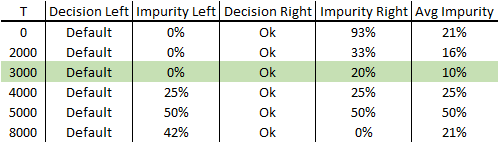

---

Add on more feature to the example

In [44]:
data = [
    [8000, 3000, 'default'],
    [2000, 1000, 'default'],
    [   0, 1000, 'default'],
    [5000, 1000, 'ok'],
    [5000, 1000, 'ok'],
    [4000, 1000, 'ok'],
    [9000, 500, 'ok'],
    [3000, 2000, 'default'],
]

df_example = pd.DataFrame(data, columns = ["assets", "debt", "status"])
df_example

,assets,debt,status
0,8000,3000,default
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
6,9000,500,ok
7,3000,2000,default


- Lets try to split the the new feature "debt"

In [45]:
df_example.sort_values("debt")

,assets,debt,status
6,9000,500,ok
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
7,3000,2000,default
0,8000,3000,default


Possible thresholds = [500, 1000, 2000]

- To generalize, put all thresholds in a dictionary

In [46]:
thresholds = {
    "assets": [0, 2000, 3000, 4000, 5000, 8000],
    "debt": [500, 1000, 2000]
} 

- Iterate through the dictionary

In [47]:
for feature, Ts in thresholds.items():
    print(20*'#')
    print(feature)
    for T in Ts:
    
        print(f"threshold: {T}")
        df_left = df_example[df_example[feature] <= T]
        df_right = df_example[df_example[feature] > T]
    
        display(df_left)
        print(df_left.status.value_counts(normalize=True))
        display(df_right)
        print(df_right.status.value_counts(normalize=True))
        print()

####################
assets
threshold: 0


,assets,debt,status
2,0,1000,default


default    1.0
Name: status, dtype: float64


,assets,debt,status
0,8000,3000,default
1,2000,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
6,9000,500,ok
7,3000,2000,default


ok         0.571429
default    0.428571
Name: status, dtype: float64

threshold: 2000


,assets,debt,status
1,2000,1000,default
2,0,1000,default


default    1.0
Name: status, dtype: float64


,assets,debt,status
0,8000,3000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
6,9000,500,ok
7,3000,2000,default


ok         0.666667
default    0.333333
Name: status, dtype: float64

threshold: 3000


,assets,debt,status
1,2000,1000,default
2,0,1000,default
7,3000,2000,default


default    1.0
Name: status, dtype: float64


,assets,debt,status
0,8000,3000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
6,9000,500,ok


ok         0.8
default    0.2
Name: status, dtype: float64

threshold: 4000


,assets,debt,status
1,2000,1000,default
2,0,1000,default
5,4000,1000,ok
7,3000,2000,default


default    0.75
ok         0.25
Name: status, dtype: float64


,assets,debt,status
0,8000,3000,default
3,5000,1000,ok
4,5000,1000,ok
6,9000,500,ok


ok         0.75
default    0.25
Name: status, dtype: float64

threshold: 5000


,assets,debt,status
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
7,3000,2000,default


ok         0.5
default    0.5
Name: status, dtype: float64


,assets,debt,status
0,8000,3000,default
6,9000,500,ok


ok         0.5
default    0.5
Name: status, dtype: float64

threshold: 8000


,assets,debt,status
0,8000,3000,default
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
7,3000,2000,default


default    0.571429
ok         0.428571
Name: status, dtype: float64


,assets,debt,status
6,9000,500,ok


ok    1.0
Name: status, dtype: float64

####################
debt
threshold: 500


,assets,debt,status
6,9000,500,ok


ok    1.0
Name: status, dtype: float64


,assets,debt,status
0,8000,3000,default
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
7,3000,2000,default


default    0.571429
ok         0.428571
Name: status, dtype: float64

threshold: 1000


,assets,debt,status
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
6,9000,500,ok


ok         0.666667
default    0.333333
Name: status, dtype: float64


,assets,debt,status
0,8000,3000,default
7,3000,2000,default


default    1.0
Name: status, dtype: float64

threshold: 2000


,assets,debt,status
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
6,9000,500,ok
7,3000,2000,default


ok         0.571429
default    0.428571
Name: status, dtype: float64


,assets,debt,status
0,8000,3000,default


default    1.0
Name: status, dtype: float64



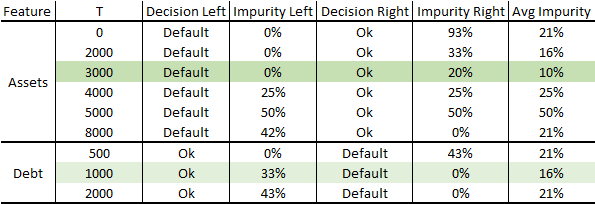

Debt is not as usefull as Assets to make the split. Assets = 3000 is still the best split

**Stop criteria** for split:

- Split is already pure (Impurity = 0%)
- Tree reached depth limit
- Group to small to split

Decision Tree in scikit-learn documentation:https://scikit-learn.org/stable/modules/tree.html

## Decision trees parameter tuning

There are many parameters to tune a DecisionTree, but the focus will be on:

- **max_depth**: The maximal depth of the tree
- **min_samples_leaf**: The minimum number of samples required to be at a leaf node

Starting with max_depth and with one of its possible values being None, that is, with no restritions

In [49]:
for d in [1, 2, 3, 4, 5, 6, 10, 15, 20, None]:
    dt = DecisionTreeClassifier(max_depth = d)
    dt.fit(X_train, y_train)
    
    y_pred = dt.predict_proba(X_val)[:, 1]
    
    auc = roc_auc_score(y_val, y_pred)
    
    print('%4s -> %.3f' % (d, auc))

   1 -> 0.606
   2 -> 0.669
   3 -> 0.739
   4 -> 0.761
   5 -> 0.766
   6 -> 0.756
  10 -> 0.697
  15 -> 0.673
  20 -> 0.650
None -> 0.655


- The best values are between a max_depth of 4 and 6, so the tree should have a depth for 4 to 6 layers.

- If this was the only parameter, the max_depth = 4 will make the tree more simple and easy for interpretation

Analyse the min_samples_leaf values for max_depth between 4 and 6

In [50]:
for d in [4, 5, 6]:
    for s in [1, 2, 5, 10, 15, 20, 100, 200, 500]:
        dt = DecisionTreeClassifier(max_depth = d, min_samples_leaf = s)
        dt.fit(X_train, y_train)
        
        y_pred = dt.predict_proba(X_val)[:,1]
        
        auc = roc_auc_score(y_val, y_pred)
        
        print('(%4s, %3d) -> %.3f' % (d, s, auc))
        # print(f"depth: {str(d):4s}, min_sample_leaf: {s:4}, auc: {auc:.3f}")

(   4,   1) -> 0.761
(   4,   2) -> 0.761
(   4,   5) -> 0.761
(   4,  10) -> 0.761
(   4,  15) -> 0.764
(   4,  20) -> 0.761
(   4, 100) -> 0.756
(   4, 200) -> 0.747
(   4, 500) -> 0.680
(   5,   1) -> 0.767
(   5,   2) -> 0.766
(   5,   5) -> 0.768
(   5,  10) -> 0.762
(   5,  15) -> 0.772
(   5,  20) -> 0.774
(   5, 100) -> 0.763
(   5, 200) -> 0.759
(   5, 500) -> 0.680
(   6,   1) -> 0.758
(   6,   2) -> 0.766
(   6,   5) -> 0.762
(   6,  10) -> 0.778
(   6,  15) -> 0.786
(   6,  20) -> 0.774
(   6, 100) -> 0.776
(   6, 200) -> 0.768
(   6, 500) -> 0.680


To get more readability, put the results in a DataFrame

In [51]:
scores = []

for d in [4, 5, 6]:
    for s in [1, 2, 5, 10, 15, 20, 100, 200, 500]:
        dt = DecisionTreeClassifier(max_depth = d, min_samples_leaf = s)
        dt.fit(X_train, y_train)
        
        y_pred = dt.predict_proba(X_val)[:,1]
        
        auc = roc_auc_score(y_val, y_pred)
        
        scores.append((d, s, auc))

In [58]:
columns = ['max_depth', 'min_samples_leaf', 'auc']

df_scores = pd.DataFrame(scores, columns = columns)
df_scores.head()

,max_depth,min_samples_leaf,auc
0,4,1,0.761283
1,4,2,0.761283
2,4,5,0.761283
3,4,10,0.761283
4,4,15,0.763726


In [61]:
df_scores.sort_values(by = 'auc', ascending = False)

,max_depth,min_samples_leaf,auc
22,6,15,0.785080
21,6,10,0.777521
24,6,100,0.776434
14,5,20,0.774028
23,6,20,0.773337
13,5,15,0.771806
25,6,200,0.768267
11,5,5,0.768173
9,5,1,0.766938
10,5,2,0.766938


- Another way to read this, is by pivoting the dataframe

In [66]:
df_scores_pivot = df_scores.pivot(index = 'min_samples_leaf', columns = 'max_depth', values = 'auc')

df_scores_pivot.round(3)

max_depth,4,5,6
min_samples_leaf,,,
1,0.761,0.767,0.762
2,0.761,0.767,0.751
5,0.761,0.768,0.762
10,0.761,0.762,0.778
15,0.764,0.772,0.785
20,0.761,0.774,0.773
100,0.756,0.763,0.776
200,0.747,0.759,0.768
500,0.680,0.680,0.680


- We can use the pivot to visualize it as a heatmap

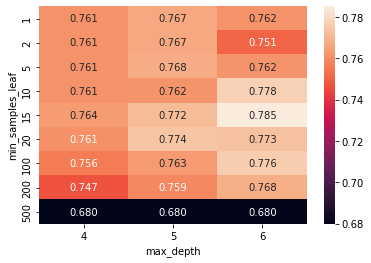

In [67]:
sns.heatmap(df_scores_pivot, annot = True, fmt = ".3f");

- Train the final DT

In [68]:
dt = DecisionTreeClassifier(max_depth = 6, min_samples_leaf = 15)
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=6, min_samples_leaf=15)

## Ensembles and random forest

Random Forest take the outputs of different Decision Trees, which are trained under a subset of different features, and in the end it makes a final predicition based on the average of there decisions (if we have a regression problem) or based on the majority class (if it is a classification problem).

The Decision Trees make the predictions independently from each others.

In [69]:
from sklearn.ensemble import RandomForestClassifier

- **n_estimators** parameters refers to the number of models, that is, number of trees in the forest

In [86]:
rf = RandomForestClassifier(n_estimators = 10)

rf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=10)

In [87]:
y_pred = rf.predict_proba(X_val)[:, 1]

In [88]:
roc_auc_score(y_val, y_pred)

0.797640526991354

Everytime we train the model for different observations, the result is different because of the premise the subset of random features

- It is important to fix a random seed for reproducibility purposes

In [89]:
rf = RandomForestClassifier(n_estimators = 10, random_state = 1)

rf.fit(X_train, y_train)
y_pred = rf.predict_proba(X_val)[:, 1]
roc_auc_score(y_val, y_pred)

0.7744726453706618

Lets iterate over the parameters of the Random Forest

- **n_estimators**

In [90]:
scores = []

for n in range(10, 201, 10):
    rf = RandomForestClassifier(n_estimators = n, random_state = 1)
    rf.fit(X_train, y_train)

    y_pred = rf.predict_proba(X_val)[:,1]

    auc = roc_auc_score(y_val, y_pred)
    scores.append((n, auc))

In [91]:
df_scores = pd.DataFrame(scores, columns=["n_estimators", "auc"])

df_scores

,n_estimators,auc
0,10,0.774473
1,20,0.803532
2,30,0.815075
3,40,0.815686
4,50,0.817082
5,60,0.816458
6,70,0.817321
7,80,0.816307
8,90,0.816824
9,100,0.817599


- Visualize the scores

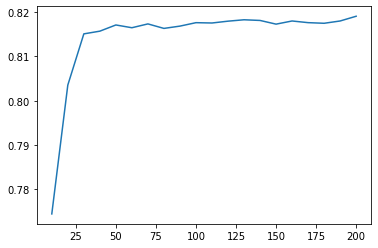

In [92]:
plt.plot(df_scores.n_estimators, df_scores.auc)

The auc stabilises at 50 trees, the performance does not really improves no matter how many more trees we add after 50.

- **max_depth**

In [93]:
scores = []

for d in [5, 10, 15]: 
    for n in range(10, 201, 10):
        rf = RandomForestClassifier(n_estimators = n, max_depth = d, random_state = 1)
        rf.fit(X_train, y_train)

        y_pred = rf.predict_proba(X_val)[:,1]

        auc = roc_auc_score(y_val, y_pred)
        scores.append((d, n, auc))

In [94]:
columns=["max_depth", "n_estimators", "auc"]
df_scores = pd.DataFrame(scores, columns = columns)
df_scores.head()

,max_depth,n_estimators,auc
0,5,10,0.787699
1,5,20,0.797731
2,5,30,0.800305
3,5,40,0.799708
4,5,50,0.799878


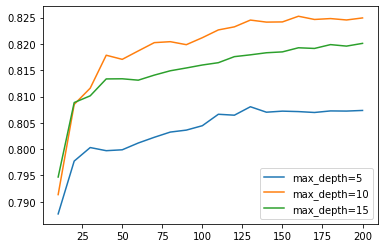

In [95]:
for d in [5, 10, 15]:
    df_subset = df_scores[df_scores.max_depth == d]
    plt.plot(df_subset.n_estimators, df_subset.auc, label = f"max_depth={d}")

plt.legend()

**max_depth** = 10 seems to be the best, it keeps performing better the max_depth = 15 after the n_estimators > 25 

- **min_samples_leaf**

In [96]:
scores = []
max_depth=10

for s in [1, 3, 5, 10, 50]:
    for n in range(10, 201, 10):
        rf = RandomForestClassifier(n_estimators = n, 
                                    max_depth = max_depth,
                                    min_samples_leaf = s,
                                    random_state = 1)
        rf.fit(X_train, y_train)

        y_pred = rf.predict_proba(X_val)[:,1]

        auc = roc_auc_score(y_val, y_pred)
        scores.append((s, n, auc))

In [97]:
columns=["min_samples_leaf", "n_estimators", "auc"]
df_scores = pd.DataFrame(scores, columns=columns)
df_scores.head()

,min_samples_leaf,n_estimators,auc
0,1,10,0.791365
1,1,20,0.808496
2,1,30,0.811584
3,1,40,0.817839
4,1,50,0.817058


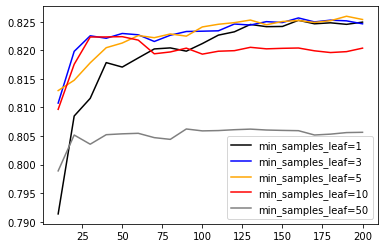

In [99]:
colors = ["black", "blue", "orange", "red", "grey"]
min_samples_leaf_values = [1, 3, 5, 10, 50]


# zip is a iterator that creates tuples between values inside list given their positions
for s, col in zip(min_samples_leaf_values, colors):
    df_subset = df_scores[df_scores.min_samples_leaf == s]
    plt.plot(df_subset.n_estimators, df_subset.auc, label = f"min_samples_leaf={s}", color = col)
plt.legend();

1, 3 and 5 have the best values. Probably pick the blue because it performs ok right at the begin

- Train the Random Forest

In [100]:
min_samples_leaf = 3

In [101]:
rf = RandomForestClassifier(n_estimators = 100, 
                                    max_depth = max_depth,
                                    min_samples_leaf = min_samples_leaf,
                                    random_state = 1)
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, min_samples_leaf=3, random_state=1)

Other useful parameters:
- **max_features**: Sets how many features each tree gets
- **bootstrap**: Another way of randomization on the row level
- **n_jobs**: To parallize the training of the Desicion Trees

Documentation: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.htm

## Gradient boosting and XGBoost

Boosting train different models sequentially, in which the model corrects the errors of the previous

In [103]:
!pip install xgboost

In [104]:
import xgboost as xgb

DMatrix is a data structure optimize for training XGBoosting models

In [105]:
features = dv.get_feature_names()

dtrain = xgb.DMatrix(X_train, label = y_train, feature_names = features)
dval = xgb.DMatrix(X_val, label = y_val, feature_names = features)

- Train the model

Documentation on parameters: https://xgboost.readthedocs.io/en/stable/parameter.html

In [109]:
xgb_params = {
    'eta': 0.3,
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'binary:logistic',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1
}

model = xgb.train(xgb_params, dtrain, num_boost_round = 200)

- Test the model

In [110]:
y_pred = model.predict(dval)

In [111]:
roc_auc_score(y_val, y_pred)

0.8003166549611296

- Monitorize the train peformance

In [112]:
watchlist = [(dtrain, 'train'), (dval, 'val')]

In [113]:
xgb_params = {
    "eta": 0.3,
    "max_depth": 6,
    "min_child_weight": 1,
    "objective": "binary:logistic",
    "eval_metric": "auc",
    "nthread": 8,
    "seed": 1,
    "verbosity": 1
}

model = xgb.train(xgb_params, dtrain, 
                  num_boost_round = 200,
                  evals = watchlist)

[0]	train-auc:0.86300	val-auc:0.76818
[1]	train-auc:0.88485	val-auc:0.79410
[2]	train-auc:0.89923	val-auc:0.80017
[3]	train-auc:0.90951	val-auc:0.80886
[4]	train-auc:0.91967	val-auc:0.80414
[5]	train-auc:0.92863	val-auc:0.80606
[6]	train-auc:0.93385	val-auc:0.80949
[7]	train-auc:0.93880	val-auc:0.81101
[8]	train-auc:0.94150	val-auc:0.81445
[9]	train-auc:0.94581	val-auc:0.81527
[10]	train-auc:0.95002	val-auc:0.81558
[11]	train-auc:0.95342	val-auc:0.81679
[12]	train-auc:0.95555	val-auc:0.81821
[13]	train-auc:0.95985	val-auc:0.81677
[14]	train-auc:0.96176	val-auc:0.81801
[15]	train-auc:0.96558	val-auc:0.81680
[16]	train-auc:0.96741	val-auc:0.81807
[17]	train-auc:0.96981	val-auc:0.81808
[18]	train-auc:0.97083	val-auc:0.81901
[19]	train-auc:0.97252	val-auc:0.81732
[20]	train-auc:0.97316	val-auc:0.81775
[21]	train-auc:0.97469	val-auc:0.81765
[22]	train-auc:0.97678	val-auc:0.81865
[23]	train-auc:0.97925	val-auc:0.81786
[24]	train-auc:0.98104	val-auc:0.81937
[25]	train-auc:0.98174	val-auc:0.81

The model is overfitting. The AUC in train data goes to 1 but in the validation set stabilizes and then starts to decrease

For redability, to not evaluate every step, we can set verbose_eval and define an increment step

In [114]:
xgb_params = {
    "eta": 0.3,
    "max_depth": 6,
    "min_child_weight": 1,
    "objective": "binary:logistic",
    "eval_metric": "auc",
    "nthread": 8,
    "seed": 1,
    "verbosity": 1
}

model = xgb.train(xgb_params, dtrain, 
                  num_boost_round = 200,
                  verbose_eval = 5,
                  evals = watchlist)

[0]	train-auc:0.86300	val-auc:0.76818
[5]	train-auc:0.92863	val-auc:0.80606
[10]	train-auc:0.95002	val-auc:0.81558
[15]	train-auc:0.96558	val-auc:0.81680
[20]	train-auc:0.97316	val-auc:0.81775
[25]	train-auc:0.98174	val-auc:0.81878
[30]	train-auc:0.98772	val-auc:0.81787
[35]	train-auc:0.99180	val-auc:0.81510
[40]	train-auc:0.99456	val-auc:0.81387
[45]	train-auc:0.99596	val-auc:0.81462
[50]	train-auc:0.99688	val-auc:0.81128
[55]	train-auc:0.99787	val-auc:0.80874
[60]	train-auc:0.99889	val-auc:0.80801
[65]	train-auc:0.99919	val-auc:0.80751
[70]	train-auc:0.99944	val-auc:0.80732
[75]	train-auc:0.99964	val-auc:0.80692
[80]	train-auc:0.99985	val-auc:0.80677
[85]	train-auc:0.99986	val-auc:0.80671
[90]	train-auc:0.99992	val-auc:0.80637
[95]	train-auc:0.99996	val-auc:0.80580
[100]	train-auc:0.99998	val-auc:0.80508
[105]	train-auc:0.99999	val-auc:0.80603
[110]	train-auc:1.00000	val-auc:0.80527
[115]	train-auc:1.00000	val-auc:0.80382
[120]	train-auc:1.00000	val-auc:0.80431
[125]	train-auc:1.0000

**To plot this results, we capture the ouput using a jupyter_notebook command** *capture* 

In [115]:
%%capture output

xgb_params = {
    "eta": 0.3,
    "max_depth": 6,
    "min_child_weight": 1,
    "objective": "binary:logistic",
    "eval_metric": "auc",
    "nthread": 8,
    "seed": 1,
    "verbosity": 1
}

model = xgb.train(xgb_params, dtrain, 
                  num_boost_round = 200,
                  verbose_eval = 5,
                  evals = watchlist)

In [116]:
print(output.stdout)

[0]	train-auc:0.86300	val-auc:0.76818
[5]	train-auc:0.92863	val-auc:0.80606
[10]	train-auc:0.95002	val-auc:0.81558
[15]	train-auc:0.96558	val-auc:0.81680
[20]	train-auc:0.97316	val-auc:0.81775
[25]	train-auc:0.98174	val-auc:0.81878
[30]	train-auc:0.98772	val-auc:0.81787
[35]	train-auc:0.99180	val-auc:0.81510
[40]	train-auc:0.99456	val-auc:0.81387
[45]	train-auc:0.99596	val-auc:0.81462
[50]	train-auc:0.99688	val-auc:0.81128
[55]	train-auc:0.99787	val-auc:0.80874
[60]	train-auc:0.99889	val-auc:0.80801
[65]	train-auc:0.99919	val-auc:0.80751
[70]	train-auc:0.99944	val-auc:0.80732
[75]	train-auc:0.99964	val-auc:0.80692
[80]	train-auc:0.99985	val-auc:0.80677
[85]	train-auc:0.99986	val-auc:0.80671
[90]	train-auc:0.99992	val-auc:0.80637
[95]	train-auc:0.99996	val-auc:0.80580
[100]	train-auc:0.99998	val-auc:0.80508
[105]	train-auc:0.99999	val-auc:0.80603
[110]	train-auc:1.00000	val-auc:0.80527
[115]	train-auc:1.00000	val-auc:0.80382
[120]	train-auc:1.00000	val-auc:0.80431
[125]	train-auc:1.0000

In [117]:
s = output.stdout

In [118]:
s

'[0]\ttrain-auc:0.86300\tval-auc:0.76818\n[5]\ttrain-auc:0.92863\tval-auc:0.80606\n[10]\ttrain-auc:0.95002\tval-auc:0.81558\n[15]\ttrain-auc:0.96558\tval-auc:0.81680\n[20]\ttrain-auc:0.97316\tval-auc:0.81775\n[25]\ttrain-auc:0.98174\tval-auc:0.81878\n[30]\ttrain-auc:0.98772\tval-auc:0.81787\n[35]\ttrain-auc:0.99180\tval-auc:0.81510\n[40]\ttrain-auc:0.99456\tval-auc:0.81387\n[45]\ttrain-auc:0.99596\tval-auc:0.81462\n[50]\ttrain-auc:0.99688\tval-auc:0.81128\n[55]\ttrain-auc:0.99787\tval-auc:0.80874\n[60]\ttrain-auc:0.99889\tval-auc:0.80801\n[65]\ttrain-auc:0.99919\tval-auc:0.80751\n[70]\ttrain-auc:0.99944\tval-auc:0.80732\n[75]\ttrain-auc:0.99964\tval-auc:0.80692\n[80]\ttrain-auc:0.99985\tval-auc:0.80677\n[85]\ttrain-auc:0.99986\tval-auc:0.80671\n[90]\ttrain-auc:0.99992\tval-auc:0.80637\n[95]\ttrain-auc:0.99996\tval-auc:0.80580\n[100]\ttrain-auc:0.99998\tval-auc:0.80508\n[105]\ttrain-auc:0.99999\tval-auc:0.80603\n[110]\ttrain-auc:1.00000\tval-auc:0.80527\n[115]\ttrain-auc:1.00000\tval-au

- Split this string

In [122]:
line = s.split("\n")[0]
line

'[0]\ttrain-auc:0.86300\tval-auc:0.76818'

There are 3 components: 
- the number of the tree or number of the iteration
- evaluation on the train data set
- evalutation on the validation data set

In [123]:
line.split("\t")

['[0]', 'train-auc:0.86300', 'val-auc:0.76818']

In [124]:
num_iter, train_auc, val_auc = line.split("\t")
num_iter, train_auc, val_auc 

('[0]', 'train-auc:0.86300', 'val-auc:0.76818')

- Turn num_iter into a number

In [125]:
num_iter

'[0]'

In [127]:
int(num_iter.strip("[]"))

0

- Turn the evaluations into floats

In [128]:
float(train_auc.split(":")[1])

0.863

In [129]:
float(val_auc.split(":")[1])

0.76818

- Generalize this for all iterations

In [130]:
def parse_xgb_output(output):
    results = []

    for line in output.stdout.strip().split('\n'):
        it_line, train_line, val_line = line.split('\t')

        it = int(it_line.strip('[]'))
        train = float(train_line.split(':')[1])
        val = float(val_line.split(':')[1])

        results.append((it, train, val))
    
    columns = ['num_iter', 'train_auc', 'val_auc']
    df_results = pd.DataFrame(results, columns=columns)
    return df_results

In [131]:
df_score = parse_xgb_output(output)
df_score.head()

,num_iter,train_auc,val_auc
0,0,0.86300,0.76818
1,5,0.92863,0.80606
2,10,0.95002,0.81558
3,15,0.96558,0.81680
4,20,0.97316,0.81775


- Finally, plot the results

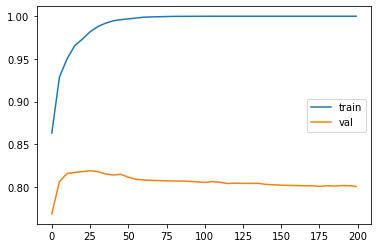

In [133]:
plt.plot(df_score.num_iter, df_score.train_auc, label = "train")
plt.plot(df_score.num_iter, df_score.val_auc, label = "val")
plt.legend()

The model is **overfitting**

## XGBoost parameter tuning

## Selecting the final model